In [1]:
!pip install mplsoccer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Sbopen,Pitch, VerticalPitch, FontManager
import math
import numpy as np
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 925.8 kB/s eta 0:00:00


In [2]:
model_path = "/content/drive/MyDrive/Football_RL/2_preparing_RL/adv_model.joblib"

# 모델 불러오기
adv_model = joblib.load(model_path)

In [3]:
mean, std=([23.86943849, 20.3750036 ], [14.63773157,  8.81828594])

In [4]:
def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(abs(np.degrees(angle)))

def calculate_distance(x, y):
  x_dist=120-x
  y_dist = abs(y - 40)  # y 거리는 y 좌표와 골대 중심 y 좌표(40)의 절대값 차이로 계산
  return math.sqrt(x_dist**2 + y_dist**2)

def calculate_xg_adv(row):
  # print(type(row['shot_first_time']))
  # print(type(row['under_pressure']))

  shot_first_time = 0 if np.isnan(row['shot_first_time']) or row['shot_first_time'] is False else 1
  under_pressure = 0 if np.isnan(row['under_pressure']) or row['under_pressure'] is False else 1

  angle = calculate_angle(row['x'], row['y'])
  distance = calculate_distance(row['x'], row['y'])

  scaled_angle = (angle - mean[0]) / std[0]
  scaled_distance = (distance - mean[1]) / std[1]


  body_part_name = {'Foot': 0, 'Head': 0}
  play_pattern_name = {'From Counter': 0, 'From Free Kick': 0,
                         'From Goal Kick': 0, 'From Keeper': 0,
                         'From Kick Off': 0, 'From Throw In': 0,
                         'From Other': 0, 'From Regular Play': 0}
  technique_name = {'Backheel': 0, 'Diving Header': 0,
                      'Half Volley': 0, 'Lob': 0,
                      'Normal': 0, 'Overhead Kick': 0,
                      'Volley': 0}
  sub_type_name = {'Corner': 0, 'Free Kick': 0,
                     'Open Play': 0, 'Penalty': 0}

  body_part_name['Head'] = 1 if row['body_part_name'] == 'Head' else 0
  body_part_name['Foot'] = 1 if row['body_part_name'] in ['Left Foot', 'Right Foot'] else 0

  if row['play_pattern_name'] in play_pattern_name:
        play_pattern_name[row['play_pattern_name']] = 1
  if row['technique_name'] in technique_name:
        technique_name[row['technique_name']] = 1
  if row['sub_type_name'] in sub_type_name:
        sub_type_name[row['sub_type_name']] = 1




  X = [[scaled_angle, scaled_distance, under_pressure,  shot_first_time,

        body_part_name['Foot'], body_part_name['Head'],

        technique_name['Backheel'], technique_name['Diving Header'],
        technique_name['Half Volley'], technique_name['Lob'],
        technique_name['Normal'], technique_name['Overhead Kick'],technique_name['Volley'],

        sub_type_name['Corner'],sub_type_name['Free Kick'], sub_type_name['Open Play'],sub_type_name['Penalty'],

        play_pattern_name['From Counter'], play_pattern_name['From Free Kick'],
        play_pattern_name['From Goal Kick'], play_pattern_name['From Keeper'],
        play_pattern_name['From Kick Off'], play_pattern_name['From Throw In'],
        play_pattern_name['From Other'], play_pattern_name['From Regular Play']]]


  xg = adv_model.predict_proba(X)[:, 1][0]
  return xg

def calculate_xag(row):
  sequence=df_frame[df_frame['id']==row['id']]
  teammate = sequence[(sequence['teammate'] == True) & (sequence['actor'] == False)]
  teammate_position=[(teammate['x'].iloc[i], teammate['y'].iloc[i]) for i in range(len(teammate))]

  xag_sum =0.0
  for position in teammate_position:
    modified_row = row.copy()
    modified_row['x'], modified_row['y'] = position

    # 각 팀메이트의 위치에서 xG 계산
    xg_value = calculate_xg_adv(modified_row)

    # 득점하지 못할 확률을 누적 곱함
    xag_sum += xg_value

    # 최종 xAG 값 계산
  xag_result = xag_sum/len(teammate_position) if len(teammate_position)>0 else 0.0
  return xag_result


In [5]:
pd.set_option('display.max_columns', 500)


In [6]:
from mplsoccer import Pitch
row = {
        'under_pressure': False,
        'shot_first_time': True,
        'x': 111.8,
        'y': 32.1,
        'body_part_name': 'Left Foot',
        'technique_name': 'Normal',
        'sub_type_name': 'Open Play',
        'play_pattern_name': 'From Counter'
}


# 함수 호출 및 출력
xg = calculate_xg_adv(row)
print("Predicted xG:", xg)

Predicted xG: 0.3034537511353778


In [8]:
if __name__=="__main__":
    parser = Sbopen()
    df_match = parser.match(competition_id=43, season_id=106)

    df_matches = {}
    for i, id in enumerate(df_match['match_id']):
        df_matches[id] = {}
        df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)
    df_frame, df_visible = parser.frame(3869685)

In [9]:
df_evaluate = df_matches[3869685]['event'].copy()  # .copy()를 사용하여 명확하게 복사본을 만들어 작업
evaluate_mask = (df_evaluate['type_name'].isin(['Clearance', 'Pass', 'Shot', 'Carry'])) & (df_evaluate['period'] <= 4)
df_evaluate = df_evaluate[evaluate_mask]

df_evaluate['xg'] = df_evaluate.apply(lambda row: calculate_xg_adv(row), axis=1)
df_evaluate['xag'] = df_evaluate.apply(lambda row: calculate_xag(row), axis=1)

df_summary=df_evaluate[['id','timestamp','possession','possession_team_name','type_name','x','y','end_x','end_y','pass_height_name','xg','xag', 'outcome_name']].copy()
df_summary['xg'] = df_summary['xg'].round(4)
df_summary['xag'] = df_summary['xag'].round(4)


In [10]:
import pandas as pd

def flatten_columns(row, df_frame):
    sequence = df_frame[df_frame['id'] == row['id']]


    actor = sequence[sequence['actor'] == True]
    actor_position = [(actor['x'].iloc[0], actor['y'].iloc[0])] if not actor.empty else [(None, None)]

    keeper = sequence[(sequence['keeper'] == True) & (sequence['teammate'] == False)]
    keeper_position = [(keeper['x'].iloc[0], keeper['y'].iloc[0])] if not keeper.empty else [(None, None)]

    teammate = sequence[(sequence['teammate'] == True) & (sequence['actor'] == False) | (sequence['keeper'] == True) & (sequence['teammate'] == True)]
    teammate_positions = [(teammate['x'].iloc[i], teammate['y'].iloc[i]) for i in range(len(teammate))]

    opponent = sequence[(sequence['teammate'] == False) & (sequence['keeper'] == False)]
    opponent_positions = [(opponent['x'].iloc[i], opponent['y'].iloc[i]) for i in range(len(opponent))]

    # 새로운 Dictionary 초기화
    flattened = {
        'id': row['id'],
        'actor_x': actor_position[0][0],
        'actor_y': actor_position[0][1],
        'keeper_x': keeper_position[0][0],
        'keeper_y': keeper_position[0][1]
    }

    # 각 teammate 위치를 별도의 열로 추가
    for i in range(10):
        if i < len(teammate_positions):
            flattened[f'teammate_{i+1}_x'] = teammate_positions[i][0]
            flattened[f'teammate_{i+1}_y'] = teammate_positions[i][1]
        else:
            flattened[f'teammate_{i+1}_x'] = None
            flattened[f'teammate_{i+1}_y'] = None

    # 각 opponent 위치를 별도의 열로 추가
    for i in range(10):
        if i < len(opponent_positions):
            flattened[f'opponent_{i+1}_x'] = opponent_positions[i][0]
            flattened[f'opponent_{i+1}_y'] = opponent_positions[i][1]
        else:
            flattened[f'opponent_{i+1}_x'] = None
            flattened[f'opponent_{i+1}_y'] = None

    return pd.Series(flattened)

id = 3857255
df_frame, _ = parser.frame(id)

# 여기서 lambda 함수를 사용하여 각 row에 대해 df_frame을 전달합니다.
flattened_dfs = df_summary.apply(lambda row: flatten_columns(row, df_frame), axis=1)

final_df = pd.merge(df_summary, flattened_dfs, how='outer', on='id')
final_df


,id,timestamp,possession,possession_team_name,type_name,x,y,end_x,end_y,pass_height_name,xg,xag,outcome_name,actor_x,actor_y,keeper_x,keeper_y,teammate_1_x,teammate_1_y,teammate_2_x,teammate_2_y,teammate_3_x,teammate_3_y,teammate_4_x,teammate_4_y,teammate_5_x,teammate_5_y,teammate_6_x,teammate_6_y,teammate_7_x,teammate_7_y,teammate_8_x,teammate_8_y,teammate_9_x,teammate_9_y,teammate_10_x,teammate_10_y,opponent_1_x,opponent_1_y,opponent_2_x,opponent_2_y,opponent_3_x,opponent_3_y,opponent_4_x,opponent_4_y,opponent_5_x,opponent_5_y,opponent_6_x,opponent_6_y,opponent_7_x,opponent_7_y,opponent_8_x,opponent_8_y,opponent_9_x,opponent_9_y,opponent_10_x,opponent_10_y
0,f651a6c4-55e3-4e0f-a178-59414ba83d6a,00:00:00,2,France,Pass,61.0,40.1,48.0,43.2,Ground Pass,0.0012,0.0003,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,9707e590-1d55-4d25-a50f-475019356152,00:00:01,2,France,Carry,48.0,43.2,49.7,43.6,NaN,0.0001,0.0001,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,a5956ecc-d637-44d2-8705-e2079e12013e,00:00:02,2,France,Pass,49.7,43.6,96.0,1.8,High Pass,0.0003,0.0006,Out,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,5ba6dfab-49f0-4225-bbb6-8b1e27bc729a,00:00:16,3,Argentina,Pass,22.7,80.0,36.0,75.2,Low Pass,0.0000,0.0000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,a511000a-bb39-4888-80e5-d81cabf8819e,00:00:17,3,Argentina,Carry,36.0,75.2,35.4,75.4,NaN,0.0000,0.0000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,3087edc7-affe-414a-a08d-7887df44156a,00:18:46,247,France,Pass,63.4,36.1,115.8,8.5,High Pass,0.0023,0.0040,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2274,dbf1a1e4-2b59-4aae-b9ca-6ffb3513afff,00:18:51,247,France,Carry,115.8,8.5,113.9,14.1,NaN,0.0076,0.0000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2275,5e6d70d0-b9ee-4ae3-8adf-546813e03ead,00:18:56,247,France,Carry,113.9,14.1,114.5,19.0,NaN,0.0149,0.0000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2276,e9a67e7c-e9ee-4df6-bd77-596cfa2c0c1e,00:18:57,247,France,Carry,114.5,19.0,111.1,25.2,NaN,0.0273,0.3198,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_frame, df_visible = parser.frame(3869685)

In [ ]:
df_summary

In [ ]:
df_summary

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

class RowToState:
    def __init__(self, row):
        self.goal_center = np.array([120, 40])
        self.goal_left = np.array([120, 44])
        self.goal_right = np.array([120, 36])
        self.row = row
        self.actor_x = row['actor_x']
        self.actor_y = row['actor_y']
        self.feature_stack = []
        self.outcome_name = ['nan', 'Incomplete', 'Out', 'Unknown', 'Pass Offside', 'success']
        self.enc = OneHotEncoder(sparse=False)
        self.enc.fit(np.array(self.outcome_name).reshape(-1, 1))

    def visualize(self):
        num_features = len(self.feature_stack)
        num_cols = 3
        num_rows = (num_features + num_cols - 1) // num_cols

        plt.figure(figsize=(15, 5 * num_rows))
        for i, feature in enumerate(self.feature_stack):
            plt.subplot(num_rows, num_cols, i + 1)
            plt.imshow(feature, cmap='viridis', interpolation='nearest')
            plt.colorbar()
            plt.title(f'Feature {i + 1}')
        plt.tight_layout()
        plt.show()

    def calculate_distance(self, x, y, target_x, target_y):
        return np.sqrt((x - target_x)**2 + (y - target_y)**2)

    def distance(self, desde):
        create_array = np.zeros((80, 120), dtype=float)
        for y in range(create_array.shape[0]):
            for x in range(create_array.shape[1]):
                if desde == "ball":
                    dist = self.calculate_distance(x, y, self.actor_x, self.actor_y)
                elif desde == "goal":
                    dist = self.calculate_distance(x, y, self.goal_center[0], self.goal_center[1])
                create_array[y, x] = dist
        self.feature_stack.append(create_array)
        return self

    def angle(self, focus, que):
        create_array = np.zeros((80, 120), dtype=float)

        # 각도 계산 및 저장
        for y in range(create_array.shape[0]):
            for x in range(create_array.shape[1]):
                my_position = np.array([x, y])

                if focus == "goalpost":
                    # 벡터 계산
                    upper_vector = self.goal_left - my_position
                    lower_vector = self.goal_right - my_position
                elif focus == "ball":
                    ball_position = np.array([self.row['actor_x'], self.row['actor_y']])
                    # 벡터 계산
                    upper_vector = ball_position - my_position
                    lower_vector = self.goal_center - my_position

                # 벡터 크기 계산
                upper_norm = np.linalg.norm(upper_vector)
                lower_norm = np.linalg.norm(lower_vector)

                # 코사인 값 계산
                if upper_norm != 0 and lower_norm != 0:
                    if que == "cosine":
                        tri_func = np.dot(upper_vector, lower_vector) / (upper_norm * lower_norm)
                    elif que == "angle":
                        cos_angle = np.dot(upper_vector, lower_vector) / (upper_norm * lower_norm)
                        tri_func = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                    elif que == "sine":
                        cross_product = upper_vector[0] * lower_vector[1] - upper_vector[1] * lower_vector[0]
                        tri_func = cross_product / (upper_norm * lower_norm)
                else:
                    tri_func = 0

                create_array[y, x] = tri_func

        self.feature_stack.append(create_array)
        return self

    def player_coor(self, row, role):
        create_array = np.zeros((80, 120), dtype=int)
        positions = []

        if role == "actor":
            positions.append((row['actor_x'], row['actor_y']))

        elif role == "teammate":
            # actor와 teammate들의 위치를 1로 설정
            positions.extend(
                (row[f'teammate_{i}_x'], row[f'teammate_{i}_y'])
                for i in range(1, 11)
                if not pd.isnull(row[f'teammate_{i}_x']) and not pd.isnull(row[f'teammate_{i}_y'])
            )
        else:
            # keeper와 opponent들의 위치를 1로 설정
            if not pd.isnull(row['keeper_x']) and not pd.isnull(row['keeper_y']):
                positions.append((row['keeper_x'], row['keeper_y']))
            positions.extend(
                (row[f'opponent_{i}_x'], row[f'opponent_{i}_y'])
                for i in range(1, 11)
                if not pd.isnull(row[f'opponent_{i}_x']) and not pd.isnull(row[f'opponent_{i}_y'])
            )

        for x, y in positions:
            x, y = int(x), int(y)
            if 0 <= y < 80 and 0 <= x < 120:
                create_array[y, x] = 1
            else:
                print(f"Index out of bounds for x={x}, y={y}")
        self.feature_stack.append(create_array)
        return self

    def outcome_label(self):
        outcome_name = str(self.row["outcome_name"])
        out_label=np.array(0 if outcome_name == "success" else 1)
        return out_label

    def destination_label(self):
        end_x = self.row["end_x"]
        end_y = self.row["end_y"]

        dest_label = np.array([end_x, end_y]).reshape(1, -1)
        return dest_label


    def stack_features(self):
        return np.stack(self.feature_stack, axis=-1)



In [12]:
  # df_evaluate= df_matches[3869685]['event']
  # df_frame, _= parser.frame(3869685)

def state_action_reward(id):
    df_evaluate= df_matches[id]['event']
    df_frame, _= parser.frame(id)


    evaluate_mask=df_evaluate['type_name'].isin(['Pass']) & (df_evaluate['period'] <= 4)
    df_evaluate = df_evaluate[evaluate_mask]
    df_summary=df_evaluate[['id','match_id','type_name','x','y','end_x','end_y','outcome_name']].copy()


    flattened_dfs = df_summary.apply(lambda row: flatten_columns(row, df_frame), axis=1)
    final_df = pd.merge(df_summary, flattened_dfs, how='outer', on='id')

    all_states=final_df.copy()
    all_states.iloc[:,8:]=all_states.iloc[:,8:].round()
    all_states.iloc[:,8:] = all_states.iloc[:,8:].applymap(lambda x: max(int(x) - 1, 0) if pd.notnull(x) else x)
    all_states['outcome_name']=all_states['outcome_name'].fillna("success")
    pass_states_surface=all_states[all_states['type_name']=="Pass"]
    pass_nan_rows = pass_states_surface.iloc[:,8:].isna().all(axis=1)
    pass_states_surface = pass_states_surface[~pass_nan_rows]
    return pass_states_surface

In [ ]:
my_select = RowToState(row)
    (
        my_select.distance("ball").distance("goal").angle("goalpost", "cosine").angle("goalpost", "sine")
        .angle("goalpost", "angle").angle("ball", "cosine").angle("ball", "sine").angle("ball", "angle")
        .player_coor(row, role="actor").player_coor(row, role="teammate").player_coor(row, role="opponent")
    )
stacked_features = my_select.stack_features()
state.append(stacked_features)
my_select.visualize()


In [ ]:
state_action_reward(3857255)

In [ ]:
result_list = []

# 메인 함수 실행
if __name__ == "__main__":
    for _, id in enumerate(df_match['match_id']):
        temp = state_action_reward(id)
        result_df = pd.concat([result_df, temp], ignore_index=True)
    result_df.to_csv("total_state_data")

In [15]:
pass_states_surface=state_action_reward(3857255)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


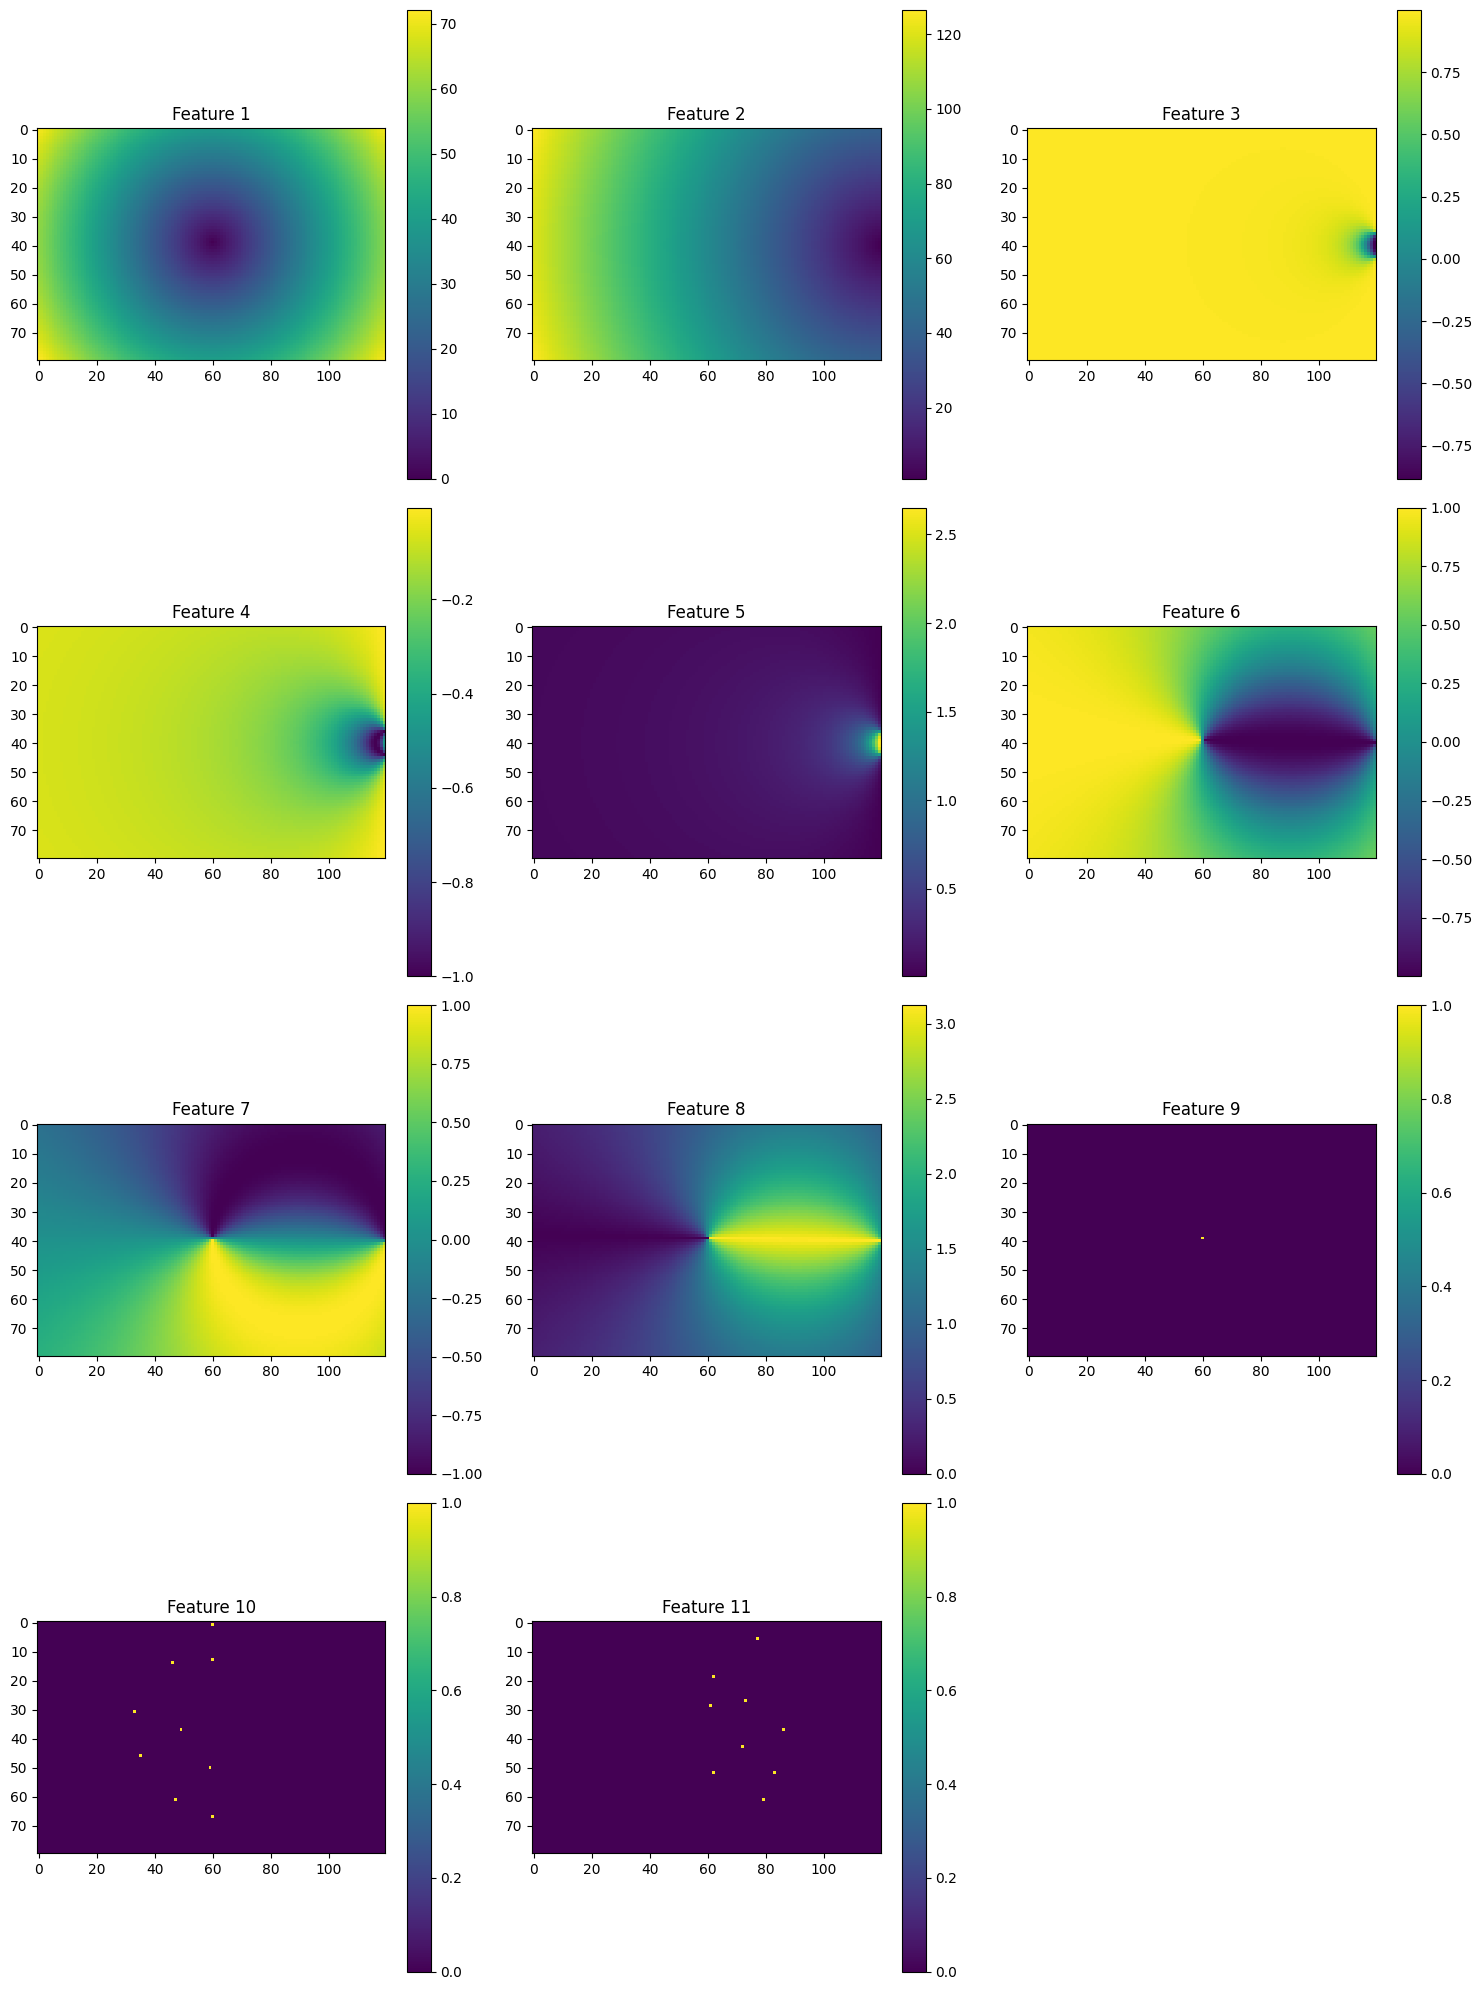

0
[[30.3 32.5]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


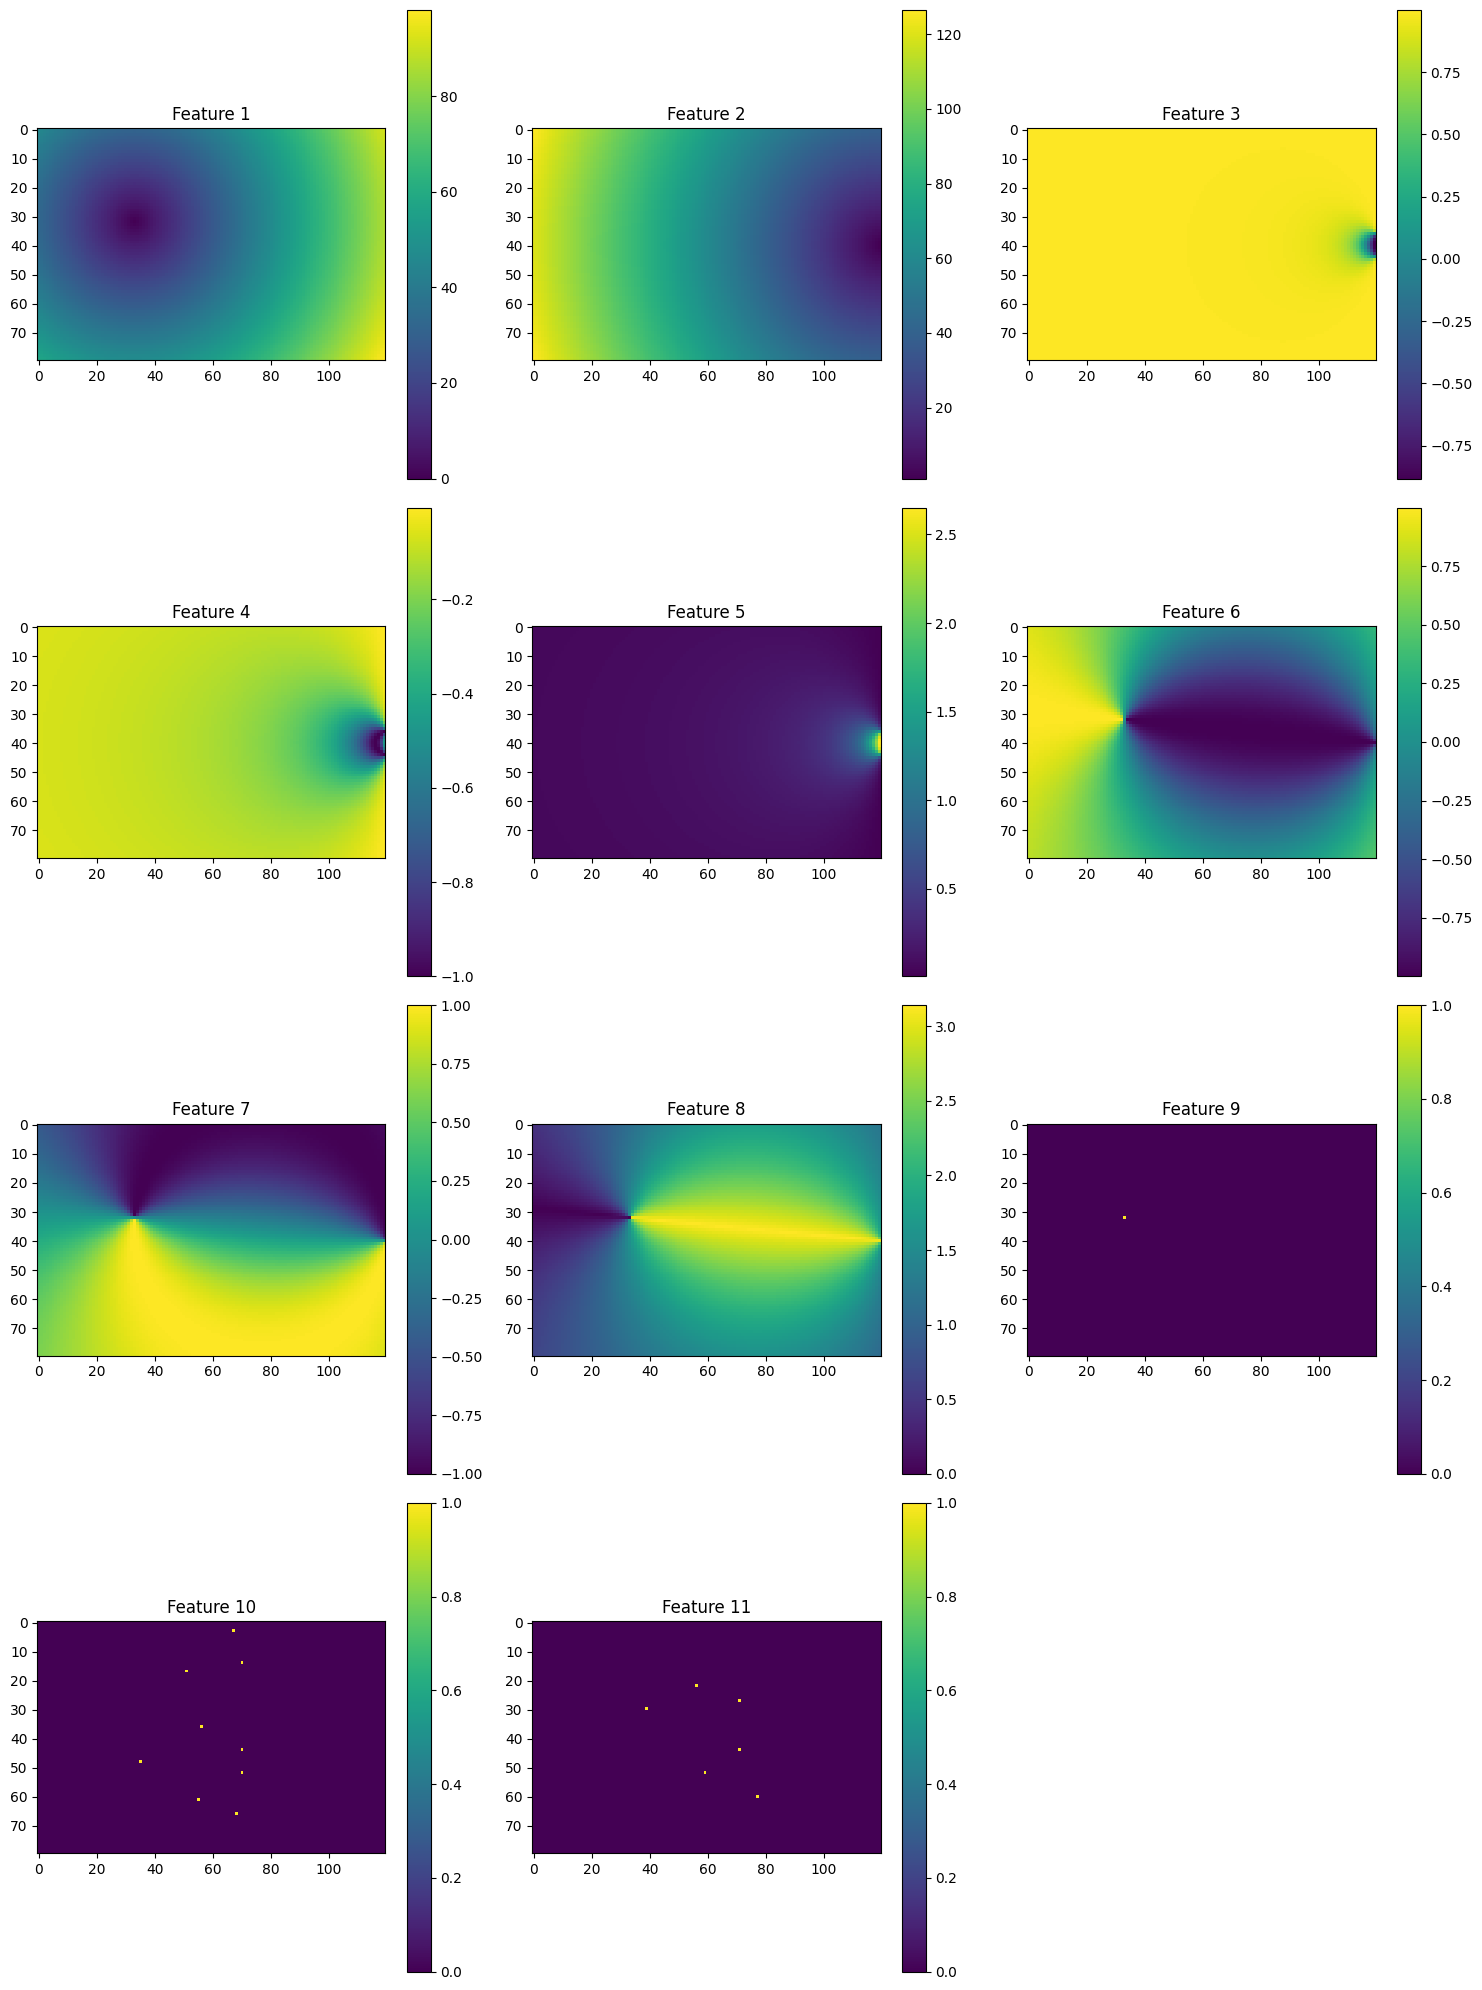

1
[[84.6 71.6]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


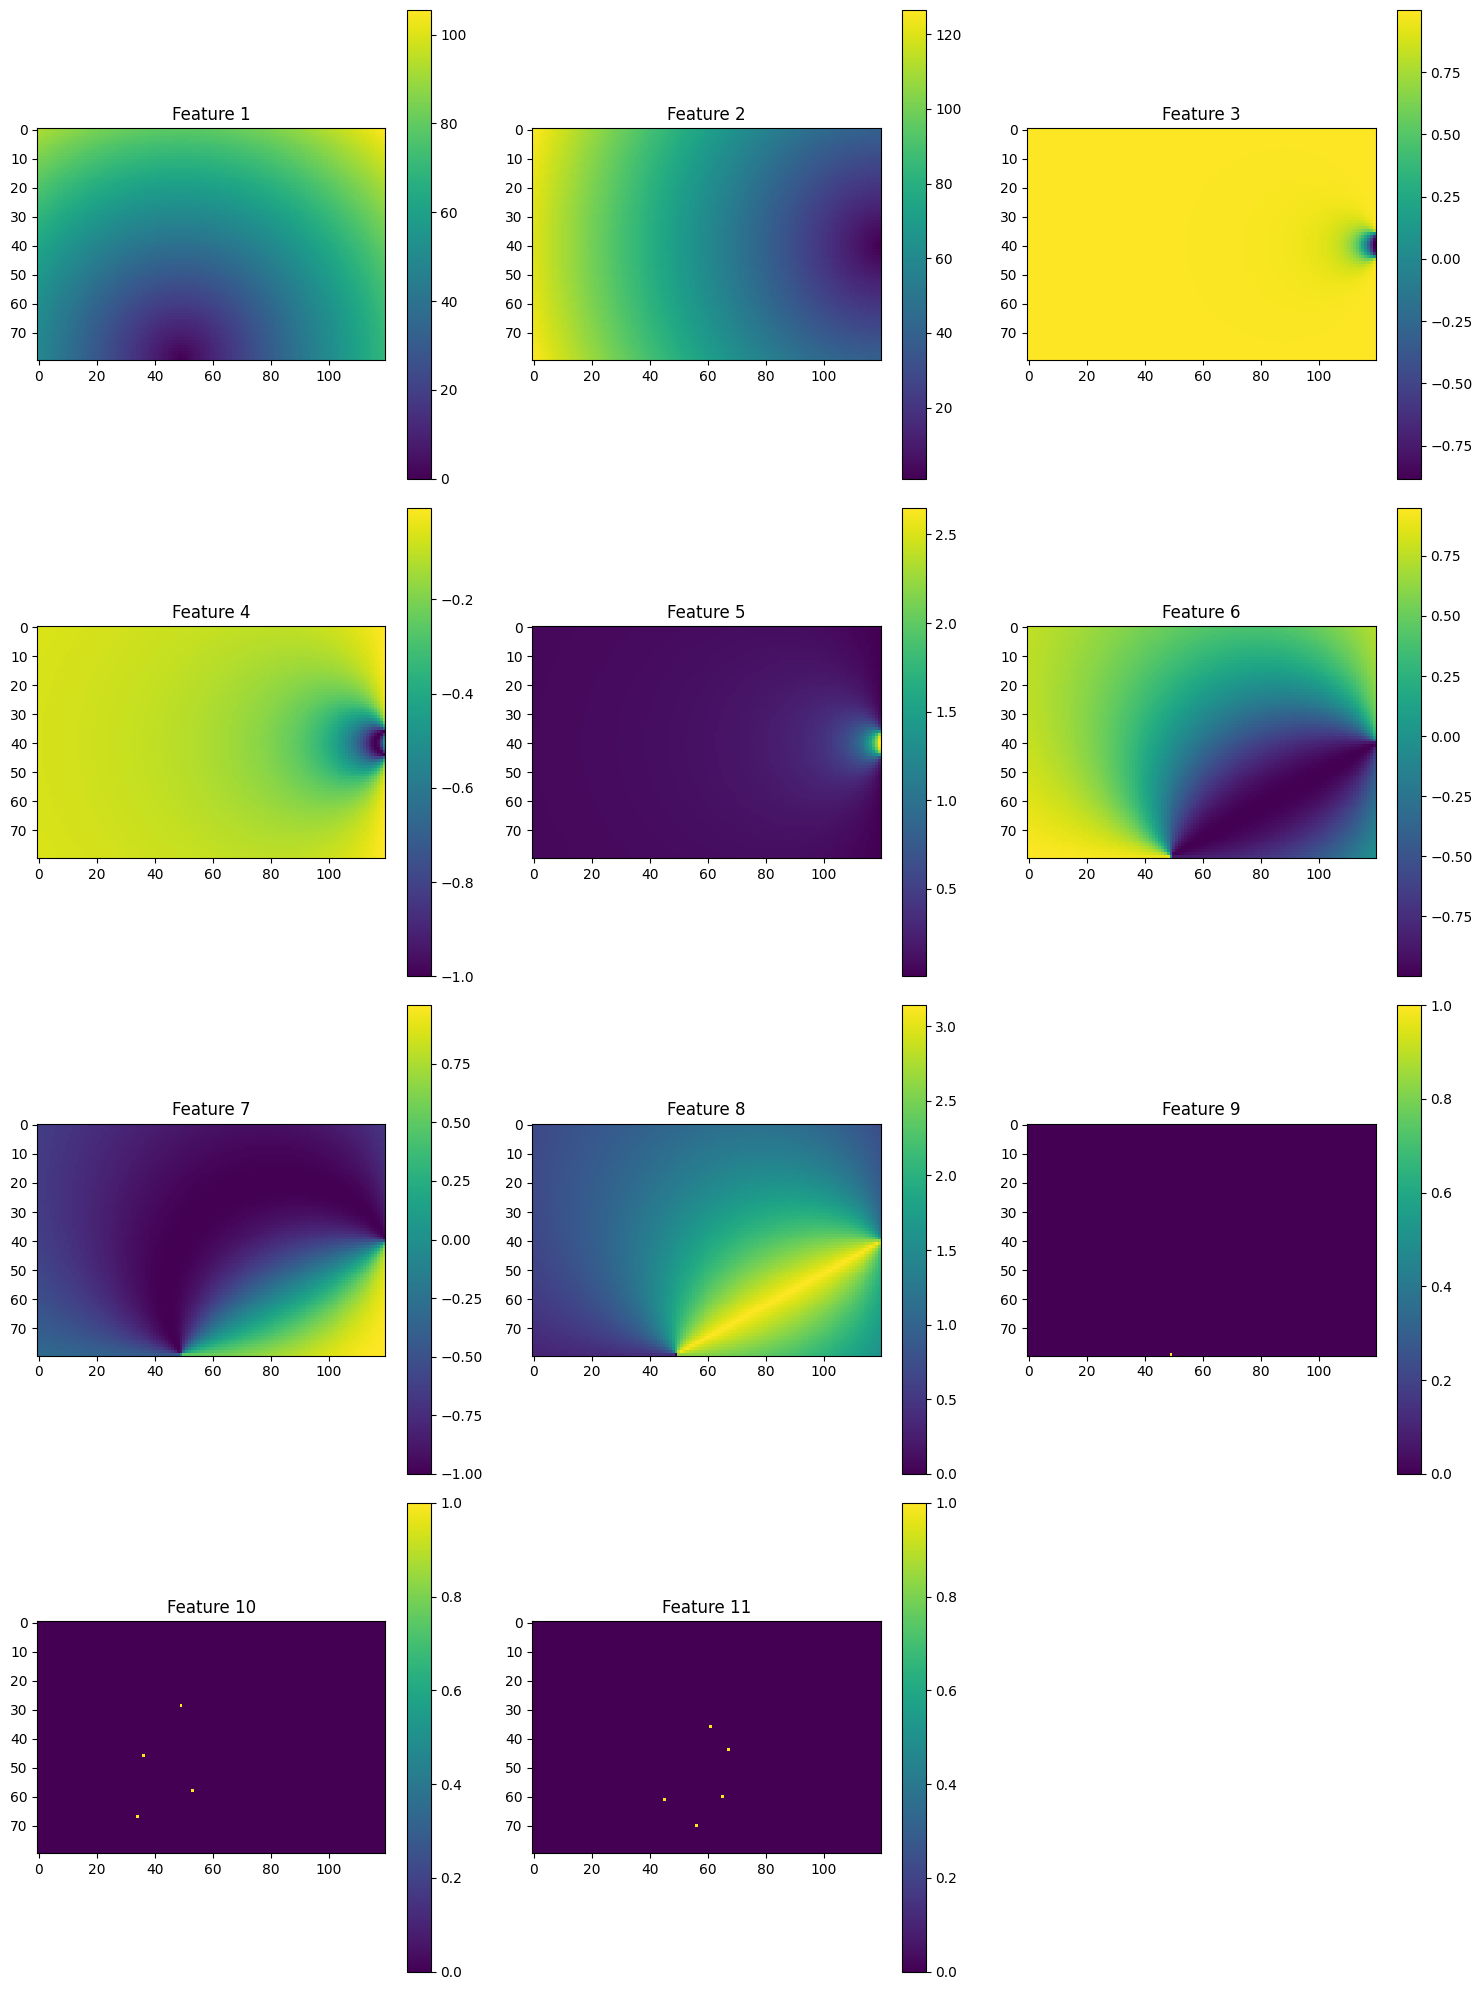

0
[[33.1 70. ]]
(3, 80, 120, 11)
[0 1 0]
[[[30.3 32.5]]

 [[84.6 71.6]]

 [[33.1 70. ]]]


In [16]:
pass_states_surface=state_action_reward(3857255)
state = []
labels = [[], []]
pass_states_surface_test = pass_states_surface.iloc[0:3, :]
for index, row in pass_states_surface_test.iterrows():
    my_select = RowToState(row)
    (
        my_select.distance("ball").distance("goal").angle("goalpost", "cosine").angle("goalpost", "sine")
        .angle("goalpost", "angle").angle("ball", "cosine").angle("ball", "sine").angle("ball", "angle")
        .player_coor(row, role="actor").player_coor(row, role="teammate").player_coor(row, role="opponent")
    )
    stacked_features = my_select.stack_features()
    state.append(stacked_features)
    my_select.visualize()

    outcome_info = my_select.outcome_label()
    labels[0].append(outcome_info)
    print(outcome_info)

    dest_info = my_select.destination_label()
    labels[1].append(dest_info)
    print(dest_info)

state_tensor = np.stack(state, axis=0)
labels[0] = np.array(labels[0])
labels[1] = np.array(labels[1])
print(state_tensor.shape)
print(labels[0])
print(labels[1])